# Fully-Connected Neural Nets
In this exercise we will implement fully-connected networks using a modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive derivative of loss with respect to outputs and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

In addition to implementing fully-connected networks of arbitrary depth, we will also explore different update rules for optimization, and introduce Dropout as a regularizer and Batch Normalization as a tool to more efficiently optimize deep networks.
  

In [147]:
# As usual, a bit of setup

import time
import numpy as np
import matplotlib.pyplot as plt
from code.classifiers.fc_net import *
from code.data_utils import get_CIFAR10_data
from code.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from code.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [148]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.iteritems():
  print '%s: ' % k, v.shape

X_val:  (1000, 3, 32, 32)
X_train:  (49000, 3, 32, 32)
X_test:  (1000, 3, 32, 32)
y_val:  (1000,)
y_train:  (49000,)
y_test:  (1000,)


# Affine layer: foward
Open the file `code/layers.py` and implement the `affine_forward` function.

Once you are done you can test your implementaion by running the following:

In [149]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around 1e-9.
print 'Testing affine_forward function:'
print 'difference: ', rel_error(out, correct_out)

Testing affine_forward function:
difference:  9.76984772881e-10


# Affine layer: backward
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [151]:
# Test the affine_backward function

x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)
# The error should be around 1e-10
print 'Testing affine_backward function:'
print 'dx error: ', rel_error(dx_num, dx)
print 'dw error: ', rel_error(dw_num, dw)
print 'db error: ', rel_error(db_num, db)

Testing affine_backward function:
dx error:  2.56115152558e-10
dw error:  4.03965514029e-11
db error:  3.21653968679e-11


# ReLU layer: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [156]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])
print out
# Compare your output with ours. The error should be around 1e-8
print 'Testing relu_forward function:'
print 'difference: ', rel_error(out, correct_out)

[[ 0.          0.          0.          0.        ]
 [ 0.          0.          0.04545455  0.13636364]
 [ 0.22727273  0.31818182  0.40909091  0.5       ]]
Testing relu_forward function:
difference:  4.99999979802e-08


# ReLU layer: backward
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [170]:
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be around 1e-12
print 'Testing relu_backward function:'
print 'dx error: ', rel_error(dx_num, dx)

Testing relu_backward function:
dx error:  3.27561660783e-12


# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `cs231n/layer_utils.py`.

For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [171]:
from code.layer_utils import affine_relu_forward, affine_relu_backward

x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

print 'Testing affine_relu_forward:'
print 'dx error: ', rel_error(dx_num, dx)
print 'dw error: ', rel_error(dw_num, dw)
print 'db error: ', rel_error(db_num, db)

Testing affine_relu_forward:
dx error:  1.62034539936e-10
dw error:  2.64902166092e-10
db error:  2.28767568263e-11


# Softmax Loss layer
Open the file `code/classifiers/layers.py` and implement the `softmax_loss` function. This is similar
to the softmax loss you implemented in the `code/classifiers/softmax.py`, but in this implementation you only have to worry about **W** and **regularization**, as this is already handled in the previous layers.

You can test that the implementations are correct by running the following:

In [176]:
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be 2.3 and dx error should be 1e-8
print '\nTesting softmax_loss:'
print 'loss: ', loss
print 'dx error: ', rel_error(dx_num, dx)


Testing softmax_loss:
loss:  2.30266991825
dx error:  8.4563509341e-09


# Two-layer network
In the `two_layer_net.ipynb` notebook you implemented a two-layer neural network in a single monolithic class. Now that you have implemented modular versions of the necessary layers, you will reimplement the two layer network using these modular implementations.

Open the file `code/classifiers/fc_net.py` and complete the implementation of the `TwoLayerNet` class. This class will serve as a model for the other networks you will implement in this assignment, so read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [177]:
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-2
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print 'Testing initialization ... '
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print 'Testing test-time forward pass ... '
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass: %f' % scores_diff

print 'Testing training loss (no regularization)'
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

for reg in [0.0, 0.7]:
  print 'Running numeric gradient check with reg = ', reg
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print '%s relative error: %.2e' % (name, rel_error(grad_num, grads[name]))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.52e-08
W2 relative error: 3.29e-10
b1 relative error: 6.55e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 2.53e-07
W2 relative error: 7.98e-08
b1 relative error: 1.09e-09
b2 relative error: 9.09e-10


# Optimization
To train the newly built network you need to update the weights with *gradient descent*. Implement the `sgd` update rule function, in `code/optim.py`. This is a modular function that simply takes in some weights **w**, some gradients **dw** and a configuration dictionary.

Test the update function with the code below:

In [178]:
from code.optim import sgd

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3}
next_w, _ = sgd(w, dw, config=config)
expected_next_w = np.asarray([
 [-0.3994,     -0.34682105, -0.29424211, -0.24166316, -0.18908421],
 [-0.13650526, -0.08392632, -0.03134737,  0.02123158,  0.07381053],
 [ 0.12638947,  0.17896842,  0.23154737,  0.28412632,  0.33670526],
 [ 0.38928421,  0.44186316,  0.49444211,  0.54702105,  0.5996    ]])


print 'next_w error: ', rel_error(next_w, expected_next_w)

next_w error:  2.51846864158e-08


# Solver
In the previous parts of this assignment, the logic for training models was coupled to the models themselves. Following a more modular design, for part we have split the logic for training models into a separate class.

Open the file `code/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves at least `50%` accuracy on the validation set.

In [196]:
model = TwoLayerNet(hidden_dim=200, reg=0.5)
solver = None

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################
solver = Solver(model, data,
                update_rule='sgd',
                optim_config={
                    'learning_rate': 1e-3,
                },
                lr_decay=0.95,
                num_epochs=10, batch_size=250,
                print_every=100)
solver.train()
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 1960) loss: 2.452692
(Epoch 0 / 10) train acc: 0.180000; val_acc: 0.139000
(Iteration 101 / 1960) loss: 1.867162
(Epoch 1 / 10) train acc: 0.425000; val_acc: 0.443000
(Iteration 201 / 1960) loss: 1.721700
(Iteration 301 / 1960) loss: 1.708383
(Epoch 2 / 10) train acc: 0.485000; val_acc: 0.457000
(Iteration 401 / 1960) loss: 1.690778
(Iteration 501 / 1960) loss: 1.648466
(Epoch 3 / 10) train acc: 0.484000; val_acc: 0.467000
(Iteration 601 / 1960) loss: 1.667173
(Iteration 701 / 1960) loss: 1.534466
(Epoch 4 / 10) train acc: 0.524000; val_acc: 0.507000
(Iteration 801 / 1960) loss: 1.567546
(Iteration 901 / 1960) loss: 1.523643
(Epoch 5 / 10) train acc: 0.562000; val_acc: 0.500000
(Iteration 1001 / 1960) loss: 1.446697
(Iteration 1101 / 1960) loss: 1.454124
(Epoch 6 / 10) train acc: 0.558000; val_acc: 0.516000
(Iteration 1201 / 1960) loss: 1.356707
(Iteration 1301 / 1960) loss: 1.444839
(Epoch 7 / 10) train acc: 0.530000; val_acc: 0.499000
(Iteration 1401 / 1960) loss: 1.50

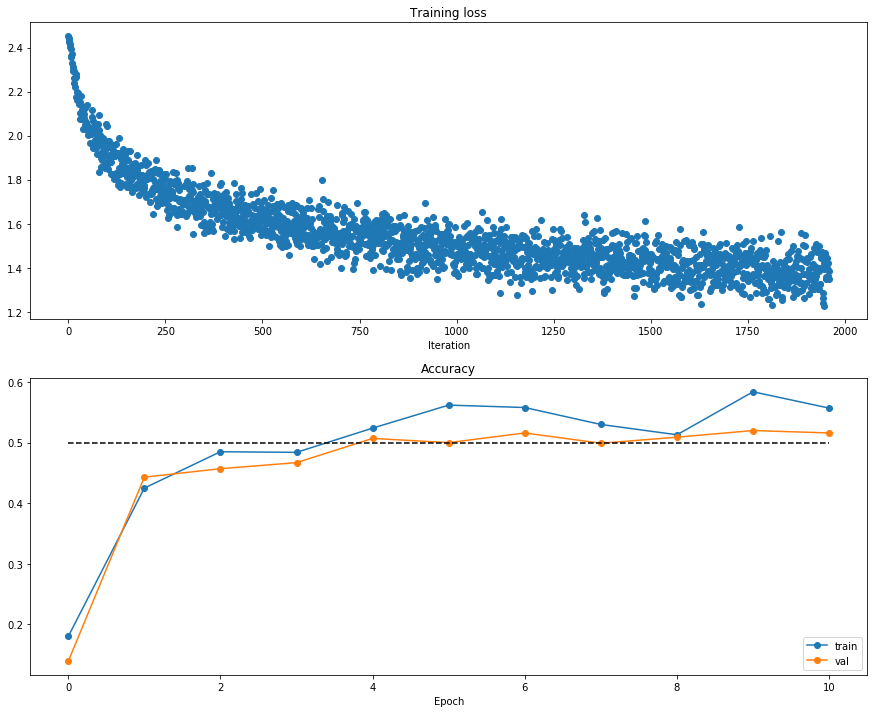

In [197]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Multilayer network
Next you will implement a fully-connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `code/classifiers/fc_net.py`.

Implement the initialization, the forward pass, and the backward pass. For the moment don't worry about implementing dropout or batch normalization; we will add those features soon.

## Initial loss and gradient check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. Do the initial losses seem reasonable?

For gradient checking, you should expect to see errors around 1e-6 or less.

In [246]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print 'Running check with reg = ', reg
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X, y)
  print 'Initial loss: ', loss

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print '%s relative error: %.2e' % (name, rel_error(grad_num, grads[name]))

Running check with reg =  0
Initial loss:  2.30006136412
W1 relative error: 1.14e-07
W2 relative error: 1.45e-06
W3 relative error: 4.79e-07
b1 relative error: 8.25e-09
b2 relative error: 3.30e-08
b3 relative error: 1.18e-10
Running check with reg =  3.14
Initial loss:  7.29774078025
W1 relative error: 2.17e-08
W2 relative error: 3.03e-08
W3 relative error: 4.97e-08
b1 relative error: 9.92e-07
b2 relative error: 6.58e-09
b3 relative error: 2.96e-10


As another sanity check, make sure you can overfit a small dataset of 50 images. First we will try a three-layer network with 100 units in each hidden layer. You will need to tweak the learning rate and initialization scale, but you should be able to overfit and achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 2.315070
(Epoch 0 / 20) train acc: 0.360000; val_acc: 0.118000
(Epoch 1 / 20) train acc: 0.380000; val_acc: 0.132000
(Epoch 2 / 20) train acc: 0.420000; val_acc: 0.132000
(Epoch 3 / 20) train acc: 0.380000; val_acc: 0.103000
(Epoch 4 / 20) train acc: 0.640000; val_acc: 0.130000
(Epoch 5 / 20) train acc: 0.560000; val_acc: 0.158000
(Iteration 11 / 40) loss: 1.408716
(Epoch 6 / 20) train acc: 0.660000; val_acc: 0.140000
(Epoch 7 / 20) train acc: 0.840000; val_acc: 0.161000
(Epoch 8 / 20) train acc: 0.780000; val_acc: 0.183000
(Epoch 9 / 20) train acc: 0.880000; val_acc: 0.143000
(Epoch 10 / 20) train acc: 0.800000; val_acc: 0.139000
(Iteration 21 / 40) loss: 0.550812
(Epoch 11 / 20) train acc: 0.780000; val_acc: 0.139000
(Epoch 12 / 20) train acc: 0.940000; val_acc: 0.169000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.187000
(Epoch 14 / 20) train acc: 0.960000; val_acc: 0.188000
(Epoch 15 / 20) train acc: 0.980000; val_acc: 0.173000
(Iteration 31 / 40) loss: 

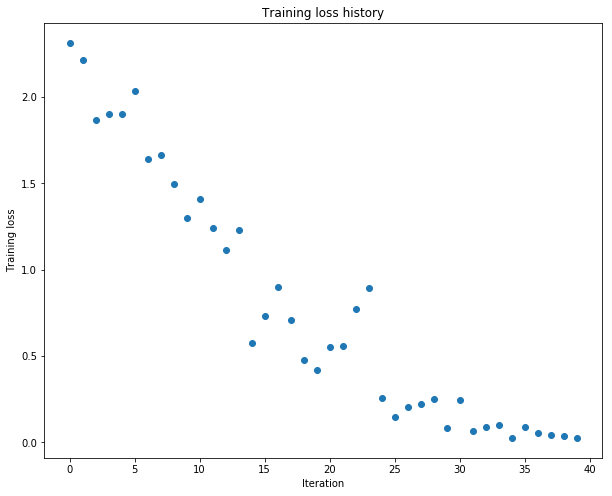

In [247]:
# TODO: Use a three-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 1e-2
learning_rate = 1e-2
model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again you will have to adjust the learning rate and weight initialization, but you should be able to achieve 100% training accuracy within 20 epochs.

In [250]:
# TODO: Use a five-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

learning_rate = 1e-2
weight_scale = 5e-2
model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

(Iteration 1 / 40) loss: 3.254577
(Epoch 0 / 20) train acc: 0.220000; val_acc: 0.100000
(Epoch 1 / 20) train acc: 0.200000; val_acc: 0.098000
(Epoch 2 / 20) train acc: 0.500000; val_acc: 0.151000
(Epoch 3 / 20) train acc: 0.740000; val_acc: 0.138000
(Epoch 4 / 20) train acc: 0.780000; val_acc: 0.142000
(Epoch 5 / 20) train acc: 0.900000; val_acc: 0.151000
(Iteration 11 / 40) loss: 0.624545
(Epoch 6 / 20) train acc: 0.980000; val_acc: 0.152000
(Epoch 7 / 20) train acc: 1.000000; val_acc: 0.152000
(Epoch 8 / 20) train acc: 1.000000; val_acc: 0.148000
(Epoch 9 / 20) train acc: 1.000000; val_acc: 0.152000
(Epoch 10 / 20) train acc: 0.980000; val_acc: 0.154000
(Iteration 21 / 40) loss: 0.123340
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.156000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.160000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.160000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.154000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.162000
(Iteration 31 / 40) loss: 

# Inline question: 
Did you notice anything about the comparative difficulty of training the three-layer net vs training the five layer net?

# Answer:
The five-layer network can much easier adopt to the data and achieve faster overfitting.
This indicates, that a five layer network might be too much for the data we want to fit as we can not sufficiently make use of the available storage and adaptability.


# Train a good model!
Train the best fully-connected model that you can on CIFAR-10, storing your best solver in the `best_solver` variable. Get at least 50% accuracy on the validation set using a fully-connected net.

(Iteration 1 / 3920) loss: 2.303358
(Epoch 0 / 20) train acc: 0.143000; val_acc: 0.101000
(Epoch 1 / 20) train acc: 0.371000; val_acc: 0.422000
(Iteration 201 / 3920) loss: 1.667728
(Epoch 2 / 20) train acc: 0.423000; val_acc: 0.450000
(Iteration 401 / 3920) loss: 1.509794
(Epoch 3 / 20) train acc: 0.483000; val_acc: 0.452000
(Iteration 601 / 3920) loss: 1.525480
(Epoch 4 / 20) train acc: 0.502000; val_acc: 0.473000
(Iteration 801 / 3920) loss: 1.482512
(Epoch 5 / 20) train acc: 0.476000; val_acc: 0.481000
(Iteration 1001 / 3920) loss: 1.543243
(Epoch 6 / 20) train acc: 0.507000; val_acc: 0.474000
(Iteration 1201 / 3920) loss: 1.384828
(Epoch 7 / 20) train acc: 0.507000; val_acc: 0.491000
(Iteration 1401 / 3920) loss: 1.461001
(Epoch 8 / 20) train acc: 0.504000; val_acc: 0.503000
(Iteration 1601 / 3920) loss: 1.327670
(Epoch 9 / 20) train acc: 0.536000; val_acc: 0.498000
(Iteration 1801 / 3920) loss: 1.447418
(Epoch 10 / 20) train acc: 0.516000; val_acc: 0.504000
(Iteration 2001 / 3920

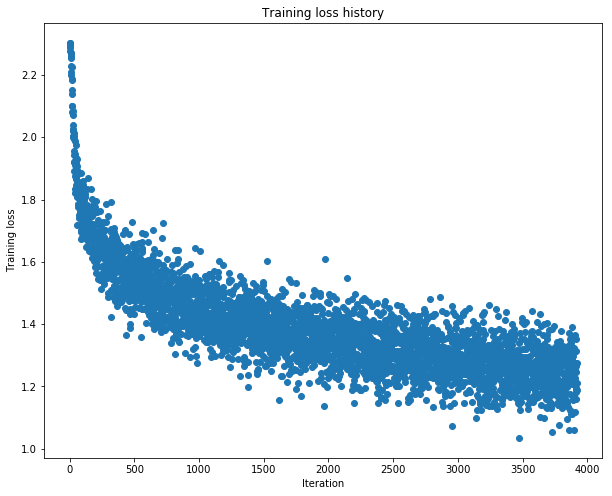

In [276]:
lr = 1e-4
ws = 2e-2
model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=ws, dtype=np.float64)

solver = Solver(model, data,
                print_every=200, num_epochs=20, batch_size=250,
                verbose=True,
                update_rule='adam',
                optim_config={
                  'learning_rate': lr,
                }
         )
solver.train()
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
best_model = best_solver.model

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

1.00e-03 / 7.00e-02 / sgd / 0.3770
1.00e-03 / 7.00e-02 / sgd_momentum / 0.4420
1.00e-03 / 7.00e-02 / rmsprop / 0.5170
1.00e-03 / 3.00e-02 / rmsprop / 0.5390
1.00e-03 / 1.00e-02 / adam / 0.5490


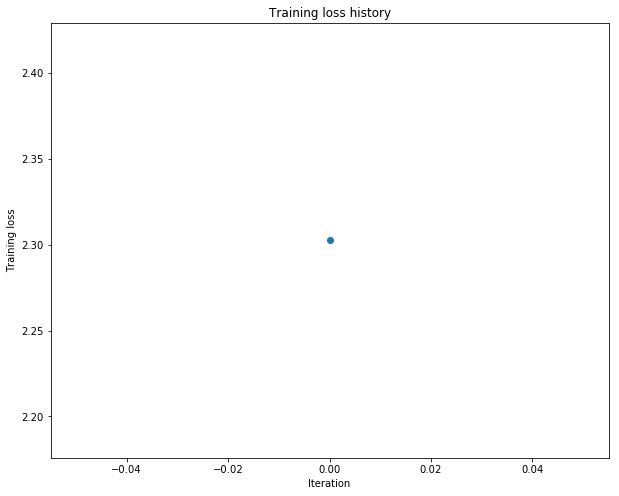

In [272]:
best_solver = None
best_acc = 0
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# batch normalization and dropout useful. Store your best model in the         #
# best_model variable.                                                         #
################################################################################

learning_rates = [1e-4, 1e-3, 1e-2, 3e-2, 6e-2, 1e-1]
weight_scales = [1e-3, 1e-2, 3e-1]
update_rules = ['sgd', 'sgd_momentum', 'rmsprop', 'adam']
for lr in learning_rates:
    for ws in weight_scales:
        for ur in update_rules:
            model = FullyConnectedNet([100, 100, 100, 100],
                            weight_scale=ws, dtype=np.float64)

            solver = Solver(model, data,
                            print_every=200, num_epochs=20, batch_size=250,
                            verbose=False,
                            update_rule=ur,
                            optim_config={
                              'learning_rate': lr,
                            }
                     )
            solver.train()
            acc = solver.check_accuracy(data['X_val'], data['y_val'])
            if acc > best_acc:
                best_solver = solver
                best_acc = acc
                print('%.2e / %.2e / %s / %.4f' % (lr, ws, ur, acc))
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
best_model = best_solver.model

plt.plot(best_solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

# Test you model
Run your best model on the validation and test sets. You should achieve above 50% accuracy on the validation set.

In [274]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print 'Validation set accuracy: ', (y_val_pred == data['y_val']).mean()
print 'Test set accuracy: ', (y_test_pred == data['y_test']).mean()

Validation set accuracy:  0.549
Test set accuracy:  0.546
